# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
import os

from sklearn.model_selection import train_test_split

from src.data import load_and_preprocess, extract_one_intervention_keys, create_two_intervention_keys, \
    create_dataset_mapping, extract_three_intervention_keys, extract_four_intervention_keys
from src.gompertz import Parameters, calculate_ages, calculate_mortality_rate
from src.interaction_factors import InteractionFactors
from src.intervention_slopes import InterventionSlopes
from src.mortality_rate import MortalityRateArguments, MortalityRateFactory, compute_mortality_by_n_interventions, \
    compute_actual_mortalities
from src.plotting import Plotter



In [2]:
# Validation Constants
VALIDATION_PERCENTAGE = 0.2
N_VALIDATION_STEPS = 20

# Intervention Constants
N_SINGLE_INTERVENTIONS = 4
NO_INTERVENTION_KEY = ''

# Dataset Contsants
DATASET_DIRECTORY = os.path.join('..', 'dat', 'final_datasets', 'female_final.csv')

# Numerical Constants
EPS = 1e-7

### Parsing the data
In this section we take the extracted values of the robust mouse rejuvination study and wrangle the data into the format needed for modeling the data.

In [3]:
# Parse data and split into training and validation sets
raw_dataset = load_and_preprocess(DATASET_DIRECTORY)
raw_train, raw_validation = train_test_split(raw_dataset, test_size=VALIDATION_PERCENTAGE, random_state=42)

# Extract the single and two intervention names
one_interventions = extract_one_intervention_keys(raw_train)
two_interventions = create_two_intervention_keys(one_interventions)

# Create a dictionary mapping intervention names to their resp. data
female_dataset = create_dataset_mapping(raw_train, one_interventions)

# Extract the three and all intervention names
three_interventions = extract_three_intervention_keys(female_dataset)
all_interventions_key = extract_four_intervention_keys(female_dataset)

### Modeling
It should be noted that from the study we have data on the following:
- No interventions
- Single Interventions
- Three Interventions
- Four (All) Interventions

Because of this we can simply fit the Gompertz curve to each of these for those resp. models. However in order to fufill the objective of finding the combination of interventions most likely to increase the lifespan of mice we still need to consider one case, that is, the case of two interventions. In order to do this in the following sections we come of with models with how interventions relate to one-another and then test how these assumptions hold on the data we have. For example, we might make an assumption on how the interventions interact with each other using only single and three intervention data. We can then validate this assumption by measuring how it performs on the all interventions. If it holds well, then we apply the same assumption to the two interventions.

After modeling the two interventions, and with regard to the assumptions, we can use the model of each case and simply take the best performing curve as our prediction of the best subset of interventions.

We keep track of the predicted slopes of the log mortality rate and use this a measure of the effectiveness of the intervention. That is, the smaller of the slope, the more better the intervention.

In [4]:
slopes = InterventionSlopes()

Here we predict the alpha and beta values for the gompertz curve for each of the intervention classes. These are used later to build the final model.

In [5]:
parameters = Parameters(female_dataset).compute()

In order for all interventions to be compared, a common set of independent variables need to be used to evaluate the model. We use the ages the mice died for the all interventions (i.e. four interventions) case for this.

In [6]:
all_interventions_ages = calculate_ages(female_dataset[all_interventions_key])

### Second-Order Model
Notation: m_i, m_ij and m_ijk are the predicted mortality rate when using interventions i; i and j; and i, j, and k resp. i_jk and i_jkl are the interaction factors of how "non-linear" the mortality rate is. That is,
i_jk = m_jk - (m_j + m_k)
i_jkl = m_jkl - (m_j + m_k + m_l)

Therefore we can come up with the following equations (1):

m_123 = m_1 + m_2 + m_3 + i_123

m_124 = m_1 + m_2 + m_4 + i_124

m_234 = m_2 + m_3 + m_4 + i_234

m_1234 = m_1 + m_2 + m_3 + m_4 + i_1234

We can make further assumptions that interactions are pairwise additive. That is,
i_123 = i_12 + i_13 + i_23

This leads us to the following equations (2):

i_123 = i_12 + i_13 + i_23

i_124 = i_12 + i_14 + i_24

i_234 = i_23 + i_24 + i_34

i_1234 = i_12 + i_13 + i_14 + i_23 + i_24 + i_34

We already know the values of the m's, but just not the i's. While equations (1) are 4 equations of 4 unknowns, meaning we can solve for the i's, unfortunately equations (2) is 4 equations of 6 unknowns therefore has multiple solutions. We use the pseudo inverse to solve it for one particular solution.

### No Interventions Prediction

In [7]:
no_intervention_arguments = MortalityRateArguments(parameters=parameters,
                                                   dataset=female_dataset,
                                                   intervention_keys=NO_INTERVENTION_KEY,
                                                   interaction_factors=None,
                                                   evaluation_ages=all_interventions_ages,
                                                   one_intervention_mortality=None)
mortality_rate_factory = MortalityRateFactory(n_interventions=0)
mortality_rate = mortality_rate_factory.create(no_intervention_arguments)
log_predicted_mortality = mortality_rate.mortality_rate.log()

slopes.add_intervention_slope('No Interventions', all_interventions_ages, log_predicted_mortality)

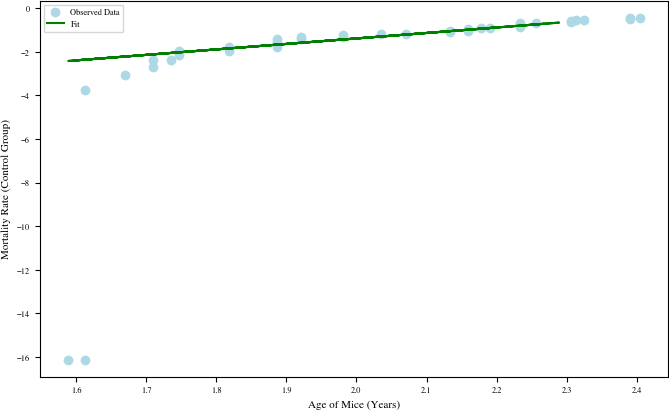

In [8]:
plotter = Plotter(female_dataset, all_interventions_ages, log_predicted_mortality, NO_INTERVENTION_KEY)
plotter.plot(n_interventions=0)


#### Single Intervention Predictions

In [9]:
one_intervention_arguments = MortalityRateArguments(parameters=parameters,
                                                   dataset=female_dataset,
                                                   intervention_keys=one_interventions,
                                                   interaction_factors=None,
                                                   evaluation_ages=all_interventions_ages,
                                                   one_intervention_mortality=None)

mortality_rate_factory = MortalityRateFactory(n_interventions=1)
mortality_rate = mortality_rate_factory.create(one_intervention_arguments)
one_interventions_mortality = mortality_rate.mortality_rate.value()
one_intervention_log_mortality = mortality_rate.mortality_rate.log()

In [10]:
def add_slopes(slopes, ages, log_mortality_rate, keys):
    for intervention_index in range(len(log_mortality_rate)):
        intervention_key = keys[intervention_index]
        slopes.add_intervention_slope(intervention_key, ages, log_mortality_rate[intervention_key])

add_slopes(slopes, all_interventions_ages, one_intervention_log_mortality, one_interventions)

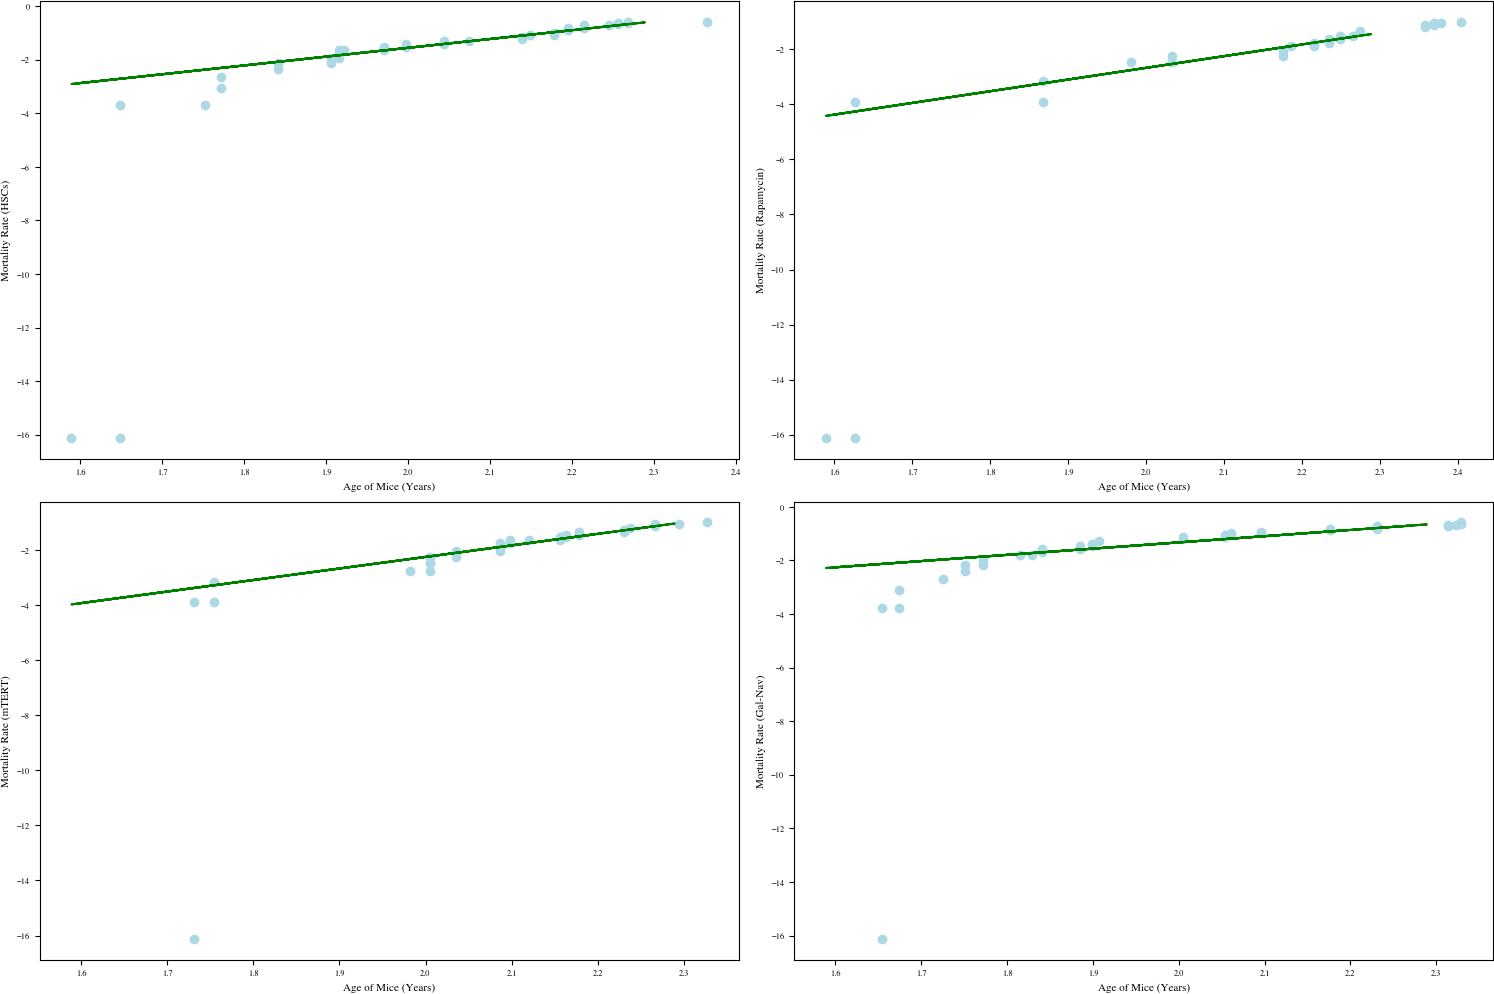

In [11]:
plotter = Plotter(female_dataset, all_interventions_ages, one_intervention_log_mortality, one_interventions)
plotter.plot(n_interventions=1)

In [12]:
all_interventions_ages = calculate_ages(female_dataset[all_interventions_key])
all_interventions_mortality_rate = calculate_mortality_rate(female_dataset[all_interventions_key])

parameters = Parameters(female_dataset).compute()
one_interventions_mortality = compute_mortality_by_n_interventions(female_dataset, all_interventions_ages, 
                                                                   parameters, one_interventions)
three_interventions_mortality = compute_mortality_by_n_interventions(female_dataset, all_interventions_ages,
                                                                     parameters, three_interventions)

The interaction factors represent the i values mentioned in the equations earlier (e.g. i_123)

In [13]:
interaction_factors = InteractionFactors(one_interventions_mortality, three_interventions_mortality)
interaction_factors.calculate()

### Two Intervention Prediction

In [14]:
two_intervention_arguments = MortalityRateArguments(parameters=parameters,
                                                    dataset=female_dataset,
                                                    intervention_keys=two_interventions,
                                                    interaction_factors=interaction_factors,
                                                    evaluation_ages=all_interventions_ages,
                                                    one_intervention_mortality=one_interventions_mortality)

mortality_rate_factory = MortalityRateFactory(n_interventions=2)
mortality_rate = mortality_rate_factory.create(two_intervention_arguments)
two_interventions_log_mortality = mortality_rate.mortality_rate.log()

In [15]:
for intervention_key, log_mortality_rate in two_interventions_log_mortality.items():
    slopes.add_intervention_slope(intervention_key, all_interventions_ages, log_mortality_rate)

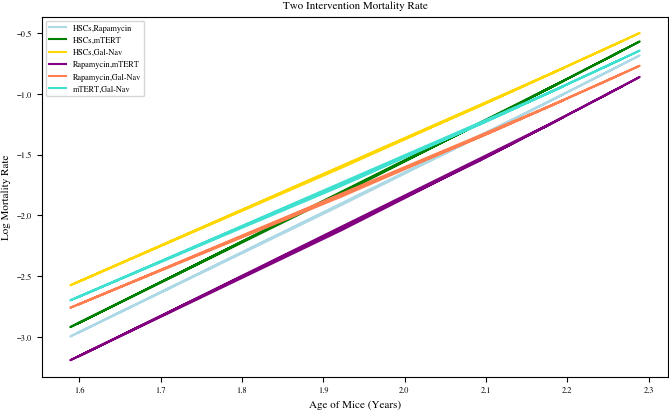

In [16]:
plotter = Plotter(female_dataset, all_interventions_ages, two_interventions_log_mortality, one_interventions)
plotter.plot(n_interventions=2)

### Three Interventions Predictions

In [17]:
three_intervention_arguments = MortalityRateArguments(parameters=parameters,
                                                      dataset=female_dataset,
                                                      intervention_keys=three_interventions,
                                                      interaction_factors=interaction_factors,
                                                      evaluation_ages=all_interventions_ages,
                                                      one_intervention_mortality=one_interventions_mortality)
mortality_rate_factory = MortalityRateFactory(n_interventions=3)
mortality_rate = mortality_rate_factory.create(three_intervention_arguments)
three_interventions_log_mortality = mortality_rate.mortality_rate.log()

In [18]:
def add_three_intervention_slopes(slopes, log_mortality, ages, keys):
    for intervention_index in range(len(log_mortality)):
        intervention_key = keys[intervention_index]
        slopes.add_intervention_slope(intervention_key, ages, log_mortality[intervention_key])


add_three_intervention_slopes(slopes, three_interventions_log_mortality, all_interventions_ages, three_interventions)

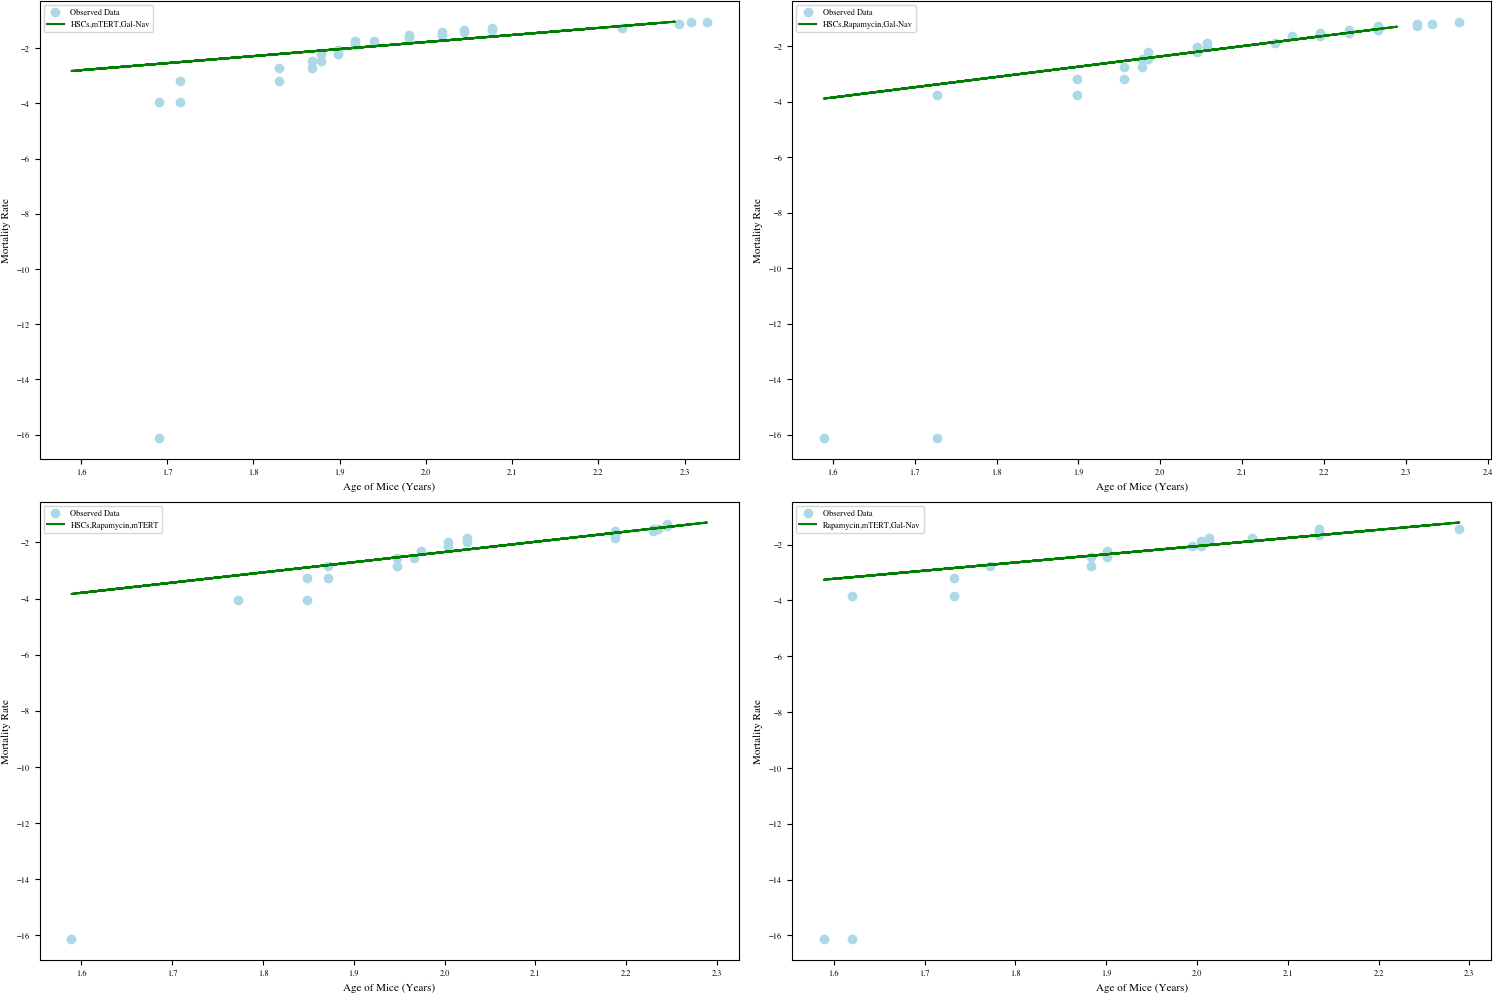

In [19]:
plotter = Plotter(female_dataset, all_interventions_ages, three_interventions_log_mortality, three_interventions)
plotter.plot(n_interventions=3)

### All Interventions Prediction

In [20]:
all_intervention_arguments = MortalityRateArguments(parameters=parameters,
                                                    dataset=female_dataset,
                                                    intervention_keys='',
                                                    interaction_factors=interaction_factors,
                                                    evaluation_ages=all_interventions_ages,
                                                    one_intervention_mortality=one_interventions_mortality)

mortality_rate_factory = MortalityRateFactory(n_interventions=4)
mortality_rate = mortality_rate_factory.create(all_intervention_arguments)
all_interventions_mortality = mortality_rate.mortality_rate.value()

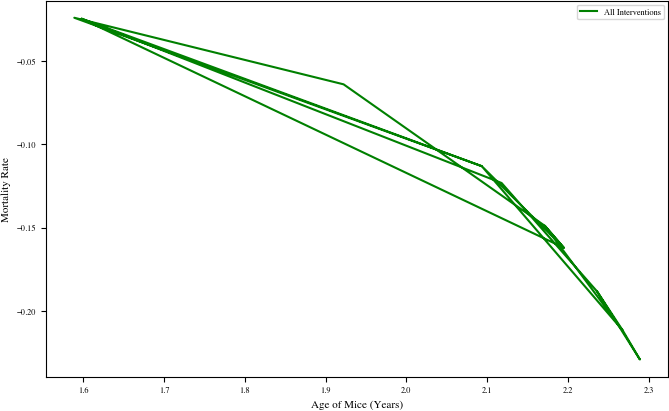

In [21]:
plotter = Plotter(female_dataset, all_interventions_ages, all_interventions_mortality, '')
plotter.plot(n_interventions=4)

### Validation

In [22]:
validation_mses = []

from random import seed, randrange

seed(a=42)

for _ in range(N_VALIDATION_STEPS):
    # Randomly split the data into training and validation data
    random_state = randrange(1_000)
    raw_train, raw_validation = train_test_split(raw_dataset, test_size=0.3, random_state=random_state)
    raw_train = raw_train.sort_index()
    raw_validation = raw_validation.sort_index()
    
    # Extract the single intervention names from the training dataset
    train_one_interventions = extract_one_intervention_keys(raw_train)
    train_two_interventions = create_two_intervention_keys(train_one_interventions)
    
    # Extract the single intervention names from the validation dataset
    validation_one_interventions = extract_one_intervention_keys(raw_validation)
    
    # Format data into a dictionary
    female_dataset_train = create_dataset_mapping(raw_train, train_one_interventions)
    female_dataset_validation = create_dataset_mapping(raw_validation, validation_one_interventions)
    
    # Extract the rest of the dataset keys
    train_three_interventions = extract_three_intervention_keys(female_dataset_train)
    all_interventions_key = extract_four_intervention_keys(female_dataset_train)
    
    # Evaluate all interventions in the train dataset with the same x-coordinates
    # by fitting each to a gompertz curve and then evaluating at the same points
    train_parameters = Parameters(female_dataset_train).compute()
    all_interventions_ages = calculate_ages(female_dataset_train[all_interventions_key])
    
    # Do the same for the validation
    validation_mortality_rates = compute_actual_mortalities(female_dataset_validation.copy(), all_interventions_ages.copy())
    
    validation_loss = 0
    count = 0

    # No Interventions Loss
    no_intervention_arguments = MortalityRateArguments(parameters=train_parameters,
                                                       dataset=female_dataset_train,
                                                       intervention_keys=NO_INTERVENTION_KEY,
                                                       interaction_factors=None,
                                                       evaluation_ages=all_interventions_ages,
                                                       one_intervention_mortality=None)
    mortality_rate_factory = MortalityRateFactory(n_interventions=0)
    mortality_rate = mortality_rate_factory.create(no_intervention_arguments)
    no_intervention_mortality = mortality_rate.mortality_rate.value()
    
    validation_loss += (no_intervention_mortality - validation_mortality_rates[''])**2
    count += 1
    
    # One Intervention Loss
    one_intervention_arguments = MortalityRateArguments(parameters=train_parameters,
                                                       dataset=female_dataset_train,
                                                       intervention_keys=train_one_interventions,
                                                       interaction_factors=None,
                                                       evaluation_ages=all_interventions_ages,
                                                       one_intervention_mortality=None)
    mortality_rate_factory = MortalityRateFactory(n_interventions=1)
    mortality_rate = mortality_rate_factory.create(one_intervention_arguments)
    one_interventions_mortality = mortality_rate.mortality_rate.value()
    
    for key in one_interventions_mortality.keys():
        if key in validation_mortality_rates:
            validation_loss += (one_interventions_mortality[key] - validation_mortality_rates[key])**2
            count += 1
    
    # Calculate Interaction Factors
    parameters = Parameters(female_dataset_train).compute()
    one_interventions_mortality = compute_mortality_by_n_interventions(female_dataset_train, all_interventions_ages, 
                                                                       parameters, train_one_interventions)
    three_interventions_mortality = compute_mortality_by_n_interventions(female_dataset_train, all_interventions_ages, 
                                                                         parameters, train_three_interventions)
    interaction_factors = InteractionFactors(one_interventions_mortality, three_interventions_mortality)
    interaction_factors.calculate()
    
    # Skip two interventions because there is no data to validate against
    
    # Three Interventions Loss
    three_intervention_arguments = MortalityRateArguments(parameters=train_parameters,
                                                          dataset=female_dataset_train,
                                                          intervention_keys=train_three_interventions,
                                                          interaction_factors=interaction_factors,
                                                          evaluation_ages=all_interventions_ages,
                                                          one_intervention_mortality=one_interventions_mortality)
    
    mortality_rate_factory = MortalityRateFactory(n_interventions=3)
    mortality_rate = mortality_rate_factory.create(three_intervention_arguments)
    three_interventions_mortality = mortality_rate.mortality_rate.value()
    
    for key in three_interventions_mortality.keys():
        if key in validation_mortality_rates:
            validation_loss += (three_interventions_mortality[key] - validation_mortality_rates[key])**2
            count += 1
    
    # All Interventions Loss
    all_intervention_arguments = MortalityRateArguments(parameters=train_parameters,
                                                        dataset=female_dataset_train,
                                                        intervention_keys=all_interventions_key,
                                                        interaction_factors=interaction_factors,
                                                        evaluation_ages=all_interventions_ages,
                                                        one_intervention_mortality=one_interventions_mortality)
    
    mortality_rate_factory = MortalityRateFactory(n_interventions=4)
    mortality_rate = mortality_rate_factory.create(all_intervention_arguments)
    
    all_interventions_mortality = mortality_rate.mortality_rate.value()
    all_validation_mortality = validation_mortality_rates[all_interventions_key]
    validation_loss += (all_interventions_mortality - all_validation_mortality)**2
    count += 1
    
    validation_mse = sum(validation_loss) / (count * len(validation_loss))
    validation_mses.append(validation_mse)

In [23]:
validation_mses

[0.008630171333723527,
 0.008710712341575555,
 0.005041926423328117,
 0.007564331168874371,
 0.008848347007782885,
 0.008617877099644252,
 0.008349573250481555,
 0.006699453898656959,
 0.00604015171778129,
 0.011671382043050842,
 0.007679847714881668,
 0.006294827006871921,
 0.006094763648258628,
 0.004638775773490613,
 0.00553796827554176,
 0.007178600902273256,
 0.006570109161289277,
 0.007454847727981851,
 0.0077585523938351105,
 0.007826742860067095]

In [24]:
print(f'The average validation mse error is {sum(validation_mses) / len(validation_mses)}')

The average validation mse error is 0.007360448087469528


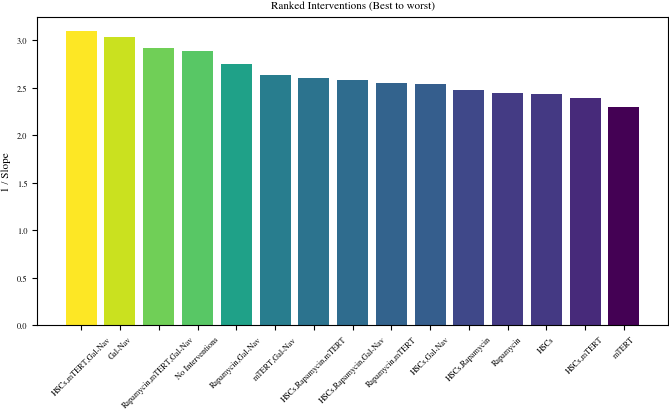

In [25]:
slopes.plot_inverse_slopes()

In the above graph, the inverse of the slope is shown for each intervention. We do this because this transform of the meaning (the inverse) means the larger the bar in the graph, the better the intervention

In [26]:
best_intervention = slopes.calculate_best_intervention()
print(f'The intervention with the best predicted increase in lifespan is "{best_intervention}".')

The intervention with the best predicted increase in lifespan is "HSCs,mTERT,Gal-Nav".


### Future Work

For future work, we recommend experimenting with other representations of the data such as survival curves rather than mortality curves as well as trying out different constraints on the linear equations.